In [151]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image

# Realidade Aumentada
O objetivo deste trabalho é detectar e localizar alvos nos quadros (frames) de um vídeo e inserir na cena objetos tridimensionais acima de cada alvo detectado. Para este trabalho, o objeto tridimensional será um cubo tridimensional e um modelo 3D (o Pikachu). Para isso, o trabalho será divido nas seguintes etapas:

1. Estimativa dos parâmetros intrínsecos da câmera
2. Detecção do alvo nos frames do vídeo
    * Transformar no espaço de cores em cinza
    * Aplicar redução de ruído
    * Binarizar a imagem
    * Encontrar os contornos
    * Filtrar contornos

## Estimativa dos parâmetros intrísecos da câmera
Para realizar essa etapa, será utilizado o Octave. Primeiramente, adicionamos o toolbox de camera calibration no Octave com o comando
```bash
addpath("<path>/<to>/<toolbox>/<parent_folder>/camera_calibration_toolbox_octave-master")
```
Então, navegamos para a pasta onde estão as imagens que queremos utilizar para a calibração de câmera. No nosso caso, são os frames do vídeo de entrada. Foram utilizados 10 frames para realizar a calibração. Após carregadas as imagens, extraimos as quinas utilizando a ferramenta visual do toolbox. Feito isso, o toolbox já possui todos os parametros necessários para realizar a calibração. Obtemos, então, os seguintes resultados:


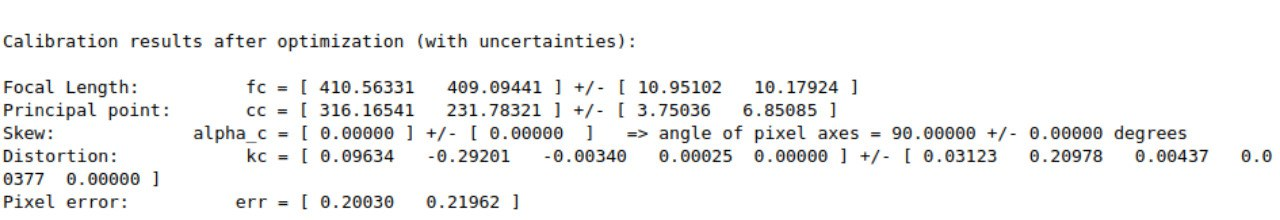

In [152]:
img = Image.open("./results/intrisics.jpeg")
img

## Detecção dos Alvos nos Frames do Vídeo


In [153]:
def binarize_img(img, use_canny=True):
    gray_scale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    b_filter = cv2.bilateralFilter(gray_scale, 9, 50, 50, cv2.BORDER_DEFAULT)
    if use_canny:
        b_filter = cv2.Canny(b_filter, 30, 200)
    _, binarized = cv2.threshold(b_filter, 127, 255, cv2.THRESH_BINARY)
    return binarized

In [154]:
def find_contours(binary_img):
    contours, _ = cv2.findContours(image=binary_img, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)
    return contours

In [155]:
def filter_contours(contours):
    MIN_AREA = 1000
    MAX_AREA = 10000
    filtered = []
    for contour in contours:
        perimeter = cv2.arcLength(contour, True)
        contour = cv2.approxPolyDP(contour, perimeter*0.03, True)
        if (len(contour) == 4 and cv2.isContourConvex(contour) and cv2.contourArea(contour) > MIN_AREA and cv2.contourArea(contour) < MAX_AREA):
            filtered.append(contour)
        
    return filtered

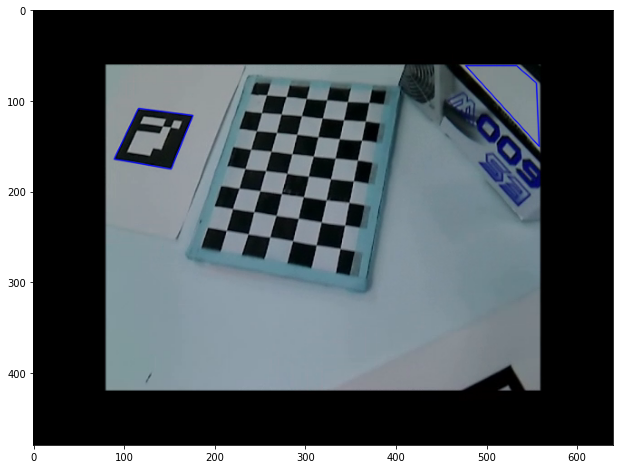

In [156]:
video = cv2.VideoCapture('./utils/entrada.mp4')
ok, nxt_frame = video.read()

for i in range(0,768):
    ok, nxt_frame = video.read()

bin = binarize_img(nxt_frame, use_canny=False)
contours = find_contours(bin)
contours = filter_contours(contours)


cnt_image = cv2.drawContours(image=nxt_frame, contours=contours, contourIdx=-1, color=(0, 0, 255), thickness=1, lineType=cv2.LINE_AA)


plt.subplots(figsize=(15, 8))
plt.imshow(cnt_image, cmap='gray')


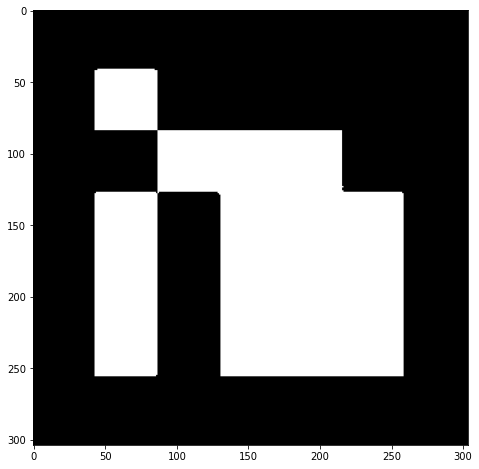

In [157]:
target = cv2.imread('./utils/alvo.jpg')
target = binarize_img(target, use_canny=False)
plt.subplots(figsize=(15, 8))
plt.imshow(target, cmap='gray')

In [162]:
def match_contour(bin_frame, contour):
    target_height, target_width = target.shape
    target_corners = np.array([[0,0], [target_width-1, 0], [target_width-1, target_height-1], [0, target_height-1]])
    homo, _ = cv2.findHomography(contour, target_corners, cv2.RANSAC, 5.0)
    proj = cv2.warpPerspective(bin_frame,homo,(target_width, target_height), flags=cv2.INTER_LINEAR)

    min_error = float("inf")
    best_angle = []

    for _, angle in enumerate([0,90,180,270]):
        rotation_matrix = cv2.getRotationMatrix2D((proj.shape[1]/2, proj.shape[0]/2), angle, 1)
        rotated = cv2.warpAffine(proj, rotation_matrix, (proj.shape[0], proj.shape[1]))
        error = np.sum(np.abs(rotated.astype("float") - target.astype("float")))
        error /= float(rotated.shape[0] * rotated.shape[1])*256

        if error < min_error:
            best_angle = angle
            min_error = error
        
    return best_angle, min_error


def find_matches(bin_frame, contours):
    MAX_ERR = 0.1
    matches_angles = []
    selected_contours = []
    for contour in contours:
        angle, err = match_contour(bin_frame, contour)
        if err < MAX_ERR:
            selected_contours.append(contour)
            matches_angles.append(angle)
    
    return selected_contours, matches_angles


contours, matches_angles = find_matches(bin, contours)

[array([[[116, 108]],

       [[176, 116]],

       [[152, 175]],

       [[ 89, 164]]], dtype=int32)]
[90]
